In [29]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from helper_functions import cyclical_encoder

import torch
import torch.nn as nn
import torch.optim as optim


ImportError: cannot import name 'cyclical_encoder' from 'helper_functions' (g:\My Drive\ITS\Tugas\Semester 4\DeepLearning-RKA\Monetary Prediction\helper_functions.py)

## Setup Device Agnostic Code

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Reading the data

In [11]:
train = pd.read_excel("data\Train.xlsx")
test = pd.read_excel("data\Test.xlsx")

In [13]:
train.head(10)

,Tahun,Bulan,HKD
0,2001,January,"1,211.66"
1,2001,February,"1,260.97"
2,2001,March,"1,333.49"
3,2001,April,"1,496.93"
4,2001,May,"1,417.82"
5,2001,June,"1,466.74"
6,2001,July,"1,221.24"
7,2001,August,"1,136.58"
8,2001,September,"1,240.44"
9,2001,October,"1,337.83"


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tahun   264 non-null    int64 
 1   Bulan   264 non-null    object
 2   HKD     264 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.3+ KB


In [14]:
train.describe()

,Tahun
count,264.000000
mean,2011.500000
std,6.356339
min,2001.000000
25%,2006.000000
50%,2011.500000
75%,2017.000000
max,2022.000000


Skewness of HKD (scipy): 0.777799091548617


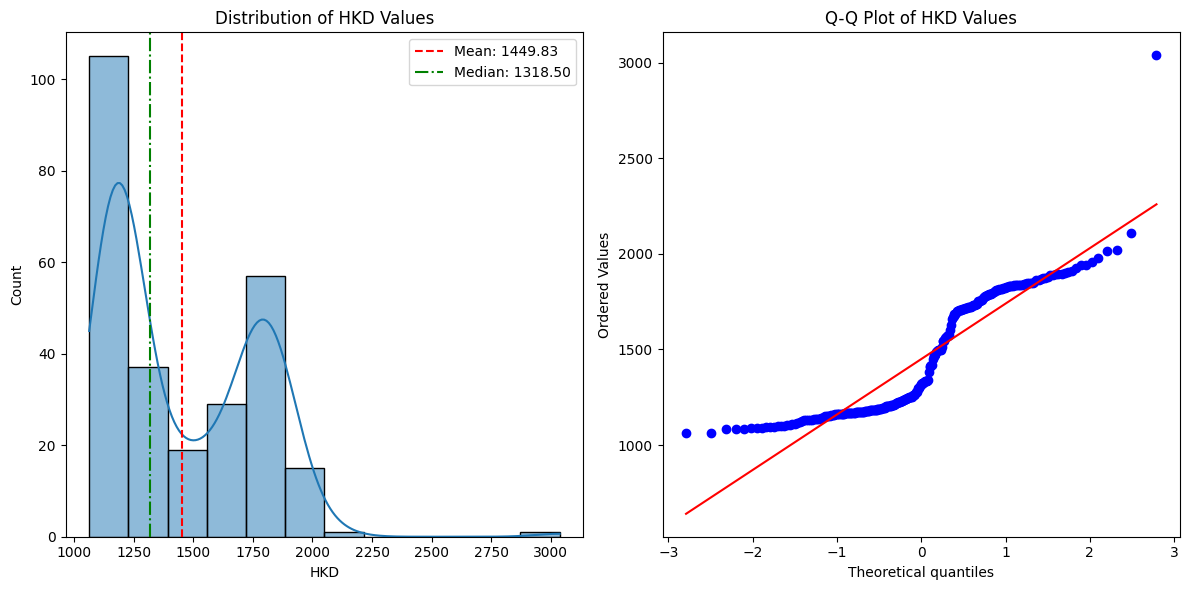

In [ ]:
# Convert 'HKD' column to numeric values
train['HKD'] = train['HKD'].str.replace(',', '').astype(float)

skewness_scipy = stats.skew(train['HKD'])
print(f"Skewness of HKD (scipy): {skewness_scipy}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train['HKD'], kde=True)
plt.title('Distribution of HKD Values')
plt.axvline(train['HKD'].mean(), color='r', linestyle='--', label=f'Mean: {train["HKD"].mean():.2f}')
plt.axvline(train['HKD'].median(), color='g', linestyle='-.', label=f'Median: {train["HKD"].median():.2f}')
plt.legend()

plt.subplot(1, 2, 2)
stats.probplot(train['HKD'], plot=plt)
plt.title('Q-Q Plot of HKD Values')

plt.tight_layout()
plt.show()

## Data Preprocessing

Sebelum melakukan memasukkan data ke dalam model, kita harus mempreproses datanya terlebih dahulu, berikut adalah langkah-langkah yang saya ambil:
1. Melakukan `Log Transformation` pada fitur `HKD`. Dilakukan untuk mengurus Skewness pada data.
2. Melakukan `Scaling` pada fitur `HKD`. Hal ini dilakukan untuk menyamakan skala dan membuat model belajar lebih baik.
3. Melakukan `Encoding` pada fitur `Bulan`. Hal ini dilakukan untuk mengubah format data yang awalnya categorical menjadi numeric agar model dapat memprosesnya lebih baik.

**NOTE**: Tidak perlu memeriksa missing values, karena ini adalah data yang sudah di olah sebelumnya

In [18]:
# Menyalin data untuk dilakukan preprocessing
train_preprocessed = train.copy()

Original skewness of HKD: 0.7778
Skewness after log transformation: 0.4004


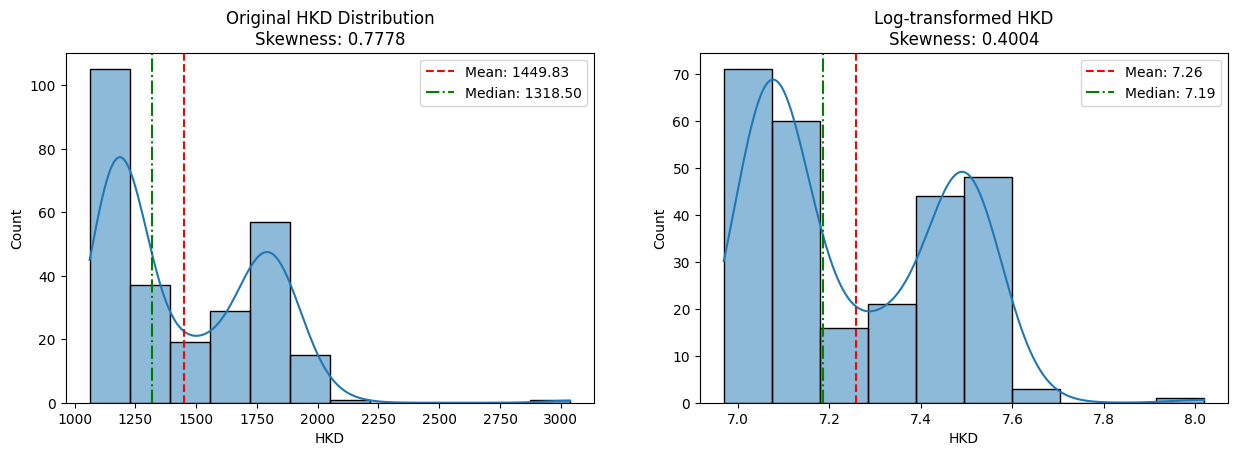

In [21]:
# Apply log transformation
train_preprocessed['HKD'] = np.log1p(train['HKD'])

# Check original skewness
print(f"Original skewness of HKD: {skewness_scipy:.4f}")

# Check skewness after log transformation
log_skewness = stats.skew(train_preprocessed['HKD'])
print(f"Skewness after log transformation: {log_skewness:.4f}")

# Visualize the original and transformed distributions
plt.figure(figsize=(15, 10))

# Original distribution
plt.subplot(2, 2, 1)
sns.histplot(train['HKD'], kde=True)
plt.title(f'Original HKD Distribution\nSkewness: {skewness_scipy:.4f}')
plt.axvline(train['HKD'].mean(), color='r', linestyle='--', label=f'Mean: {train["HKD"].mean():.2f}')
plt.axvline(train['HKD'].median(), color='g', linestyle='-.', label=f'Median: {train["HKD"].median():.2f}')
plt.legend()

# Log-transformed distribution
plt.subplot(2, 2, 2)
sns.histplot(train_preprocessed['HKD'], kde=True)
plt.title(f'Log-transformed HKD\nSkewness: {log_skewness:.4f}')
plt.axvline(train_preprocessed['HKD'].mean(), color='r', linestyle='--', label=f'Mean: {train_preprocessed["HKD"].mean():.2f}')
plt.axvline(train_preprocessed['HKD'].median(), color='g', linestyle='-.', label=f'Median: {train_preprocessed["HKD"].median():.2f}')
plt.legend()


In [24]:
scaler = StandardScaler()
train_preprocessed['HKD'] = scaler.fit_transform(train_preprocessed[['HKD']])

train_preprocessed.head()

,Tahun,Bulan,HKD
0,2001,January,-0.765426
1,2001,February,-0.571862
2,2001,March,-0.300510
3,2001,April,0.260572
4,2001,May,-0.002929


In [ ]:
def cyclical_encoder(df, col_name='Month', period=12):
    """
    Create sine and cosine transformations of a cyclical feature
    
    Parameters:
    df: DataFrame containing the column to encode
    col_name: Name of the column to encode
    period: The period of the cyclical feature (12 for months)
    
    Returns:
    DataFrame with two new columns: col_name_sin and col_name_cos
    """
    # Convert to numeric if needed
    if df[col_name].dtype == 'object':
        # Map month names to numbers if needed
        month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
        df[col_name] = df[col_name].map(month_map)
    
    # Create cyclical features
    df[f'{col_name}_sin'] = np.sin(2 * np.pi * df[col_name]/period)
    df[f'{col_name}_cos'] = np.cos(2 * np.pi * df[col_name]/period)
    
    return df

In [26]:
train_preprocessed = cyclical_encoder(train_preprocessed, col_name="Bulan", period=12)

train_preprocessed.head()

,Tahun,Bulan,HKD,Bulan_sin,Bulan_cos
0,2001,1,-0.765426,0.500000,8.660254e-01
1,2001,2,-0.571862,0.866025,5.000000e-01
2,2001,3,-0.300510,1.000000,6.123234e-17
3,2001,4,0.260572,0.866025,-5.000000e-01
4,2001,5,-0.002929,0.500000,-8.660254e-01
